In [1]:
## environment setting
%matplotlib inline
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import statsmodels.api as sm  
import seaborn as sb  
sb.set_style('darkgrid')

In [2]:
## load the original data

In [3]:
data = pd.read_csv('NASDAQ data from yahoo.csv')  
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1998-01-02,1574.099976,1581.530029,1563.770020,1581.530029,1581.530029,434140000
1,1998-01-05,1585.770020,1602.510010,1582.989990,1594.119995,1594.119995,681560000
2,1998-01-06,1588.069946,1594.119995,1576.260010,1580.140015,1580.140015,635700000
3,1998-01-07,1574.010010,1580.140015,1547.520020,1561.699951,1561.699951,691340000
4,1998-01-08,1555.910034,1566.560059,1550.699951,1555.540039,1555.540039,645050000


In [4]:
## select what we need to construct a target original data
## even though there are several fields, we focus on the daily close price

In [5]:
d=data.loc[:,('Date','Close')]
print(d.head())

         Date        Close
0  1998-01-02  1581.530029
1  1998-01-05  1594.119995
2  1998-01-06  1580.140015
3  1998-01-07  1561.699951
4  1998-01-08  1555.540039


In [6]:
##index data to d

In [7]:
d=d.set_index('Date')
print(d.head())

                  Close
Date                   
1998-01-02  1581.530029
1998-01-05  1594.119995
1998-01-06  1580.140015
1998-01-07  1561.699951
1998-01-08  1555.540039


In [8]:
##  ADF 平稳性检验定义  ##
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  

In [ ]:
# get the trend plot
## from the picture below, we can see there is one giant dip but after the dip, it tends to go up while there are a few little drops. 
## So we can say the data is non-stationary.

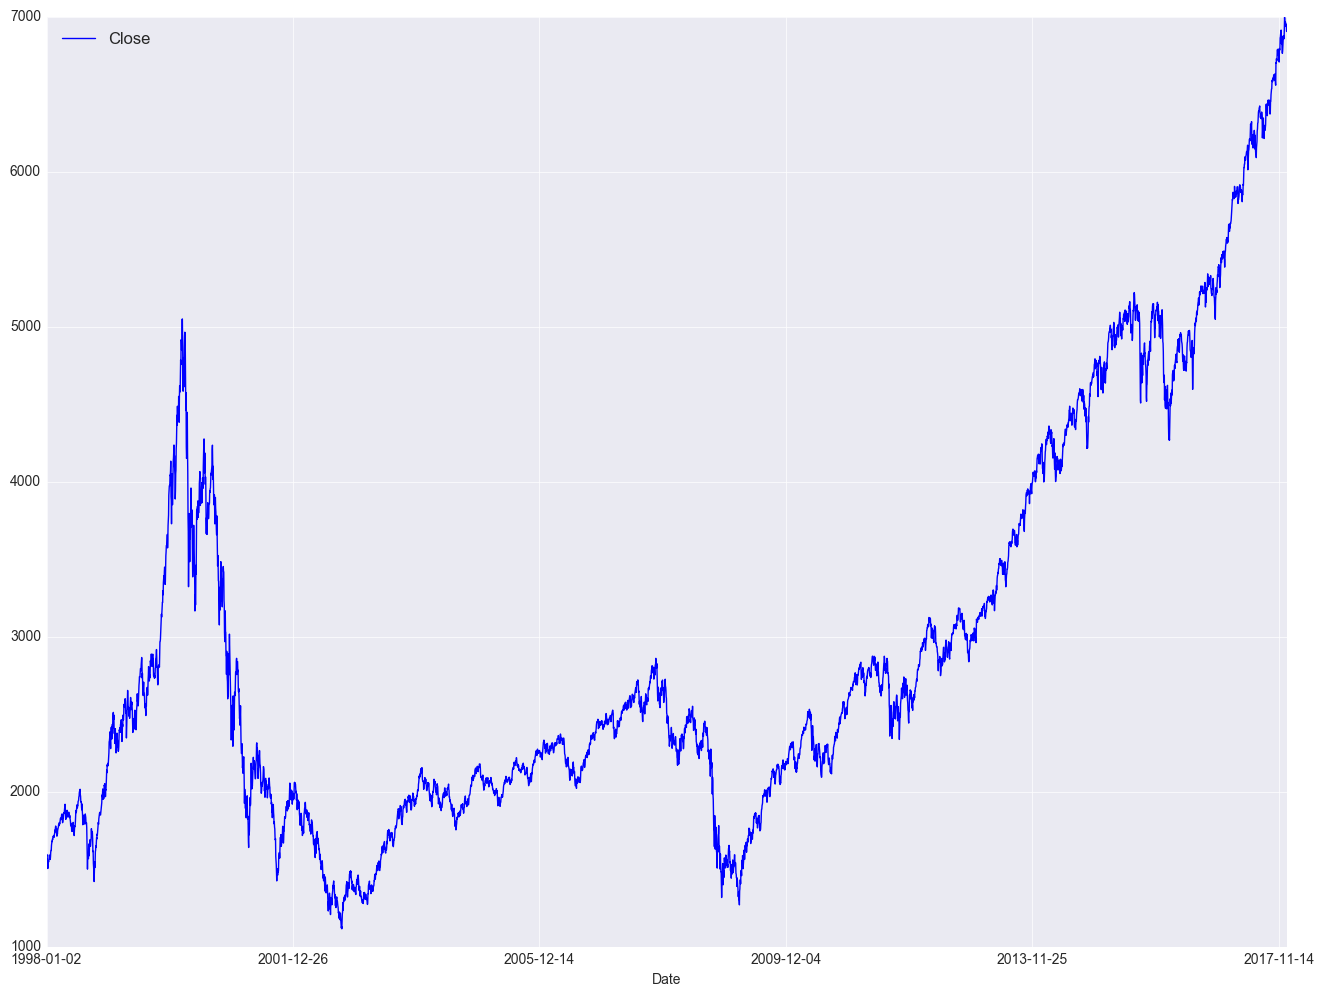

In [9]:
d.plot(figsize=(16,12))

In [10]:
## test whether the original data is stationary or not by ADF test

adf_test(d['Close'])

## p-value equals to 0.986 > 0.1, which means that it is not stationary.

Results of Augment Dickey-Fuller Test:
Test Statistic                    0.539015
p-value                           0.986012
#Lags Used                       30.000000
Number of Observations Used    5001.000000
Critical Value (5%)              -2.862118
Critical Value (10%)             -2.567078
Critical Value (1%)              -3.431658
dtype: float64


In [11]:
## In order to analyzing and building the ARIMA model, we need to transform the unstationary time serie into a stationary data set.
## in this part, we can apply first difference and/or log-transform or combination of them to the original daily close price.

In [12]:
## first application is to use first difference
## we remove the trend of data and the data is centered around 0 by subtracting the previous value t-1 from the current value.

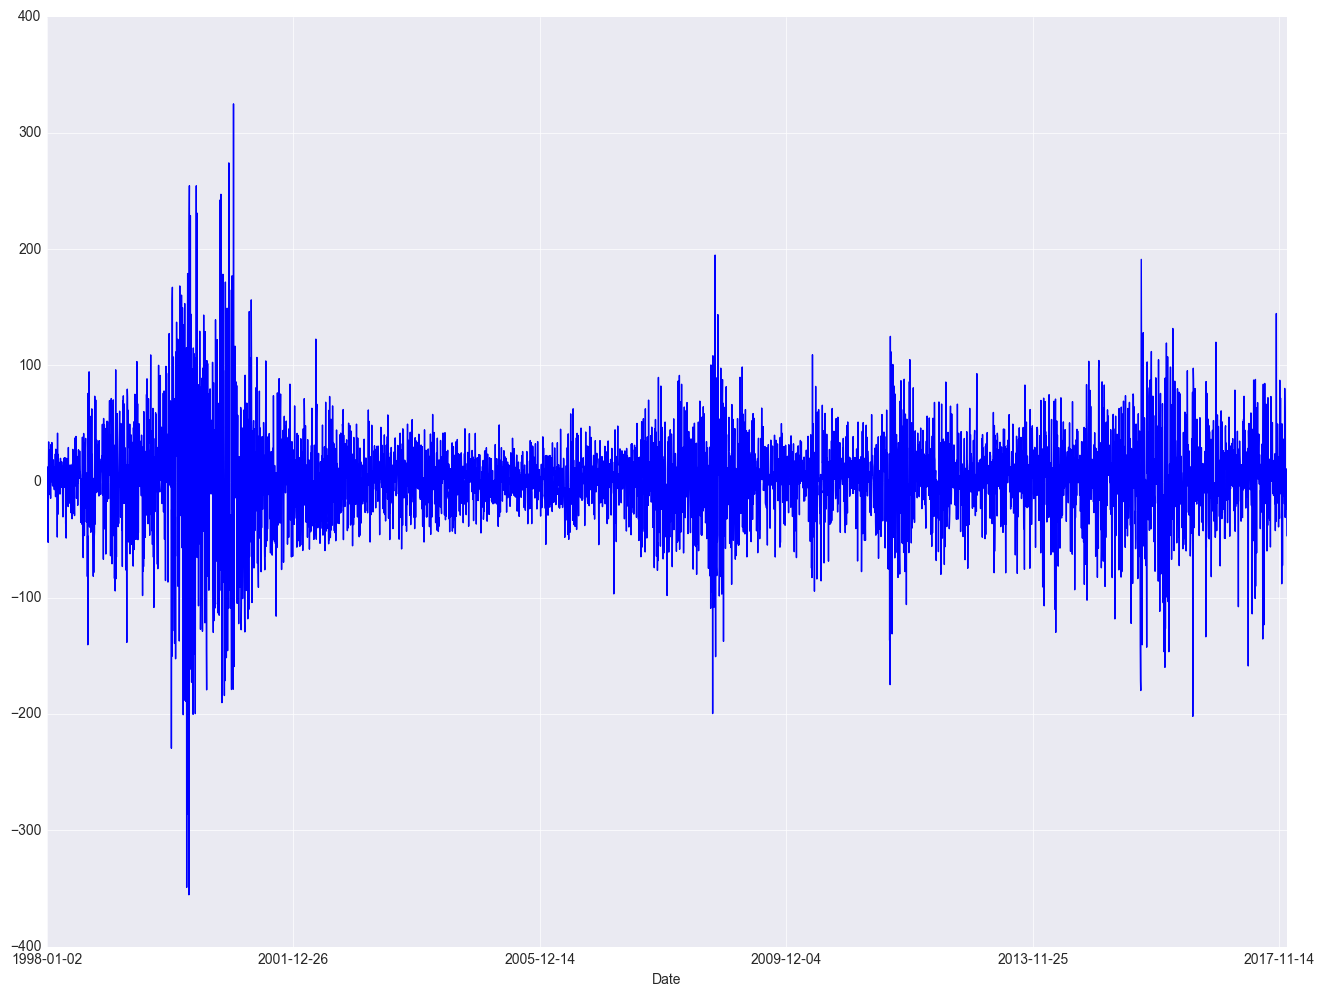

In [13]:
d['first difference']=d['Close']-d['Close'].shift()
d['first difference'].plot(figsize=(16,12))

In [14]:
## According to the plot above, there is no trend to go up anymore and the data fluctuates around 0.

In [15]:
## test whether the data after first difference is stationary or not by ADF test

adf_test(d['first difference'].iloc[1:])

## p-value equals to 3.8564e-22 < 0.01, which means that it is stationary.

Results of Augment Dickey-Fuller Test:
Test Statistic                -1.197314e+01
p-value                        3.856391e-22
#Lags Used                     2.900000e+01
Number of Observations Used    5.001000e+03
Critical Value (5%)           -2.862118e+00
Critical Value (10%)          -2.567078e+00
Critical Value (1%)           -3.431658e+00
dtype: float64


In [16]:
## Second, applying the log-transform to the original data

## From the picture below, we can see there are still two big dips 
## and lots of small declines and it tends to go up like the original plot. 

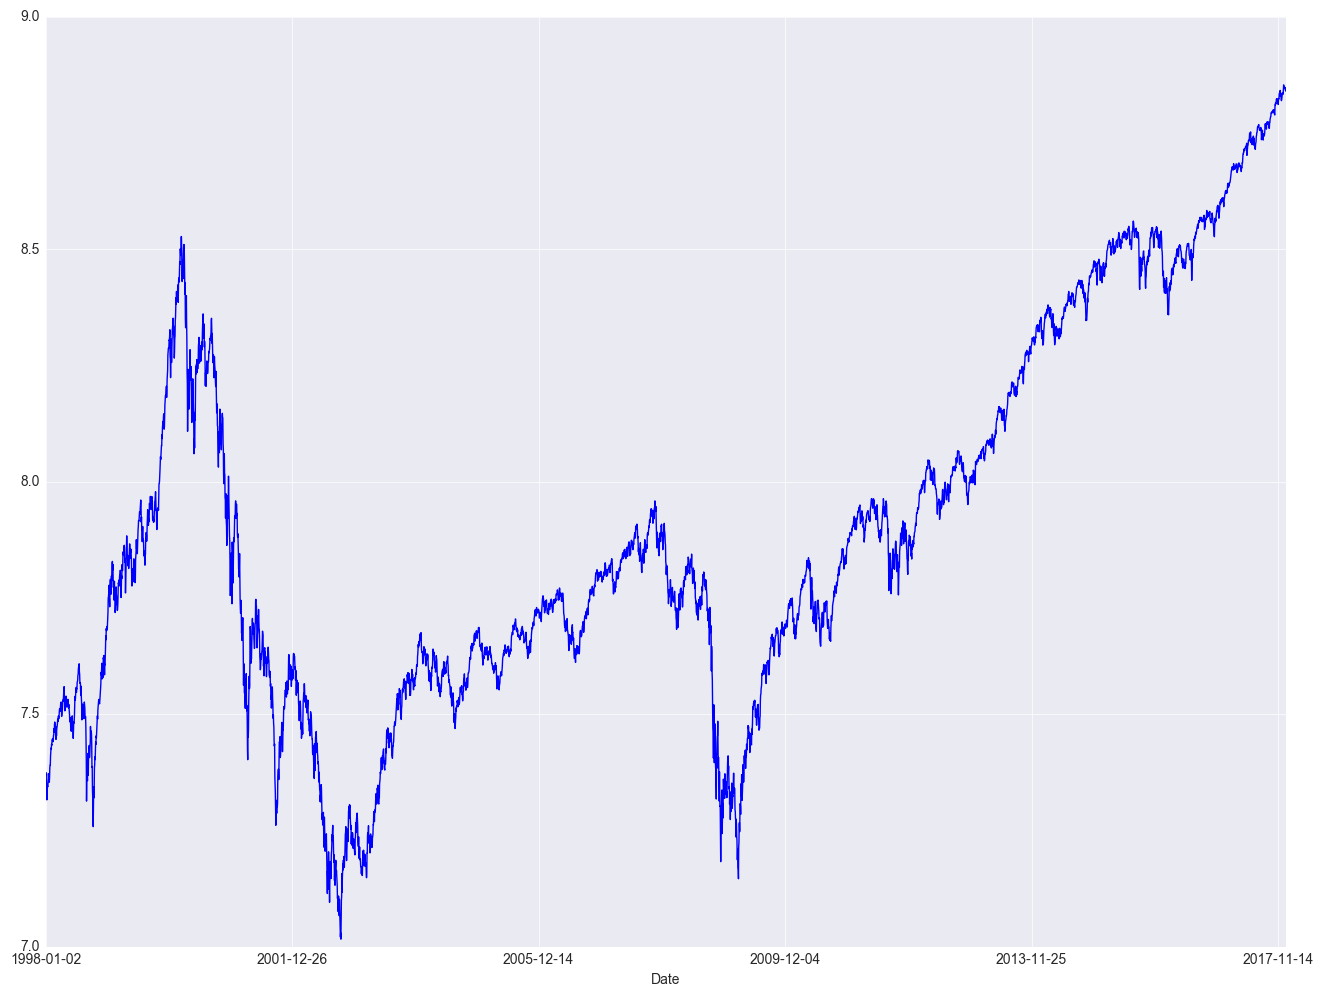

In [17]:
d['natural log']=d['Close'].apply(lambda x: np.log(x))
d['natural log'].plot(figsize=(16,12))

In [18]:
## test whether the data after first difference is stationary or not by ADF test

adf_test(d['natural log'])

## By ADF test, we have p-value is 0.837426 > 0.1 
## and the test statistics is -0.735177 greater than all the critical value (even 10%).
## we can say the data after log-transformation is still non-stationary. But it flatten the data.

Results of Augment Dickey-Fuller Test:
Test Statistic                   -0.735177
p-value                           0.837426
#Lags Used                       27.000000
Number of Observations Used    5004.000000
Critical Value (5%)              -2.862118
Critical Value (10%)             -2.567078
Critical Value (1%)              -3.431657
dtype: float64


In [19]:
## Third, applying the combination of log-transform and first difference to the original data

##In view of the plot below, the data has no trend and it stays steadily around 0. 

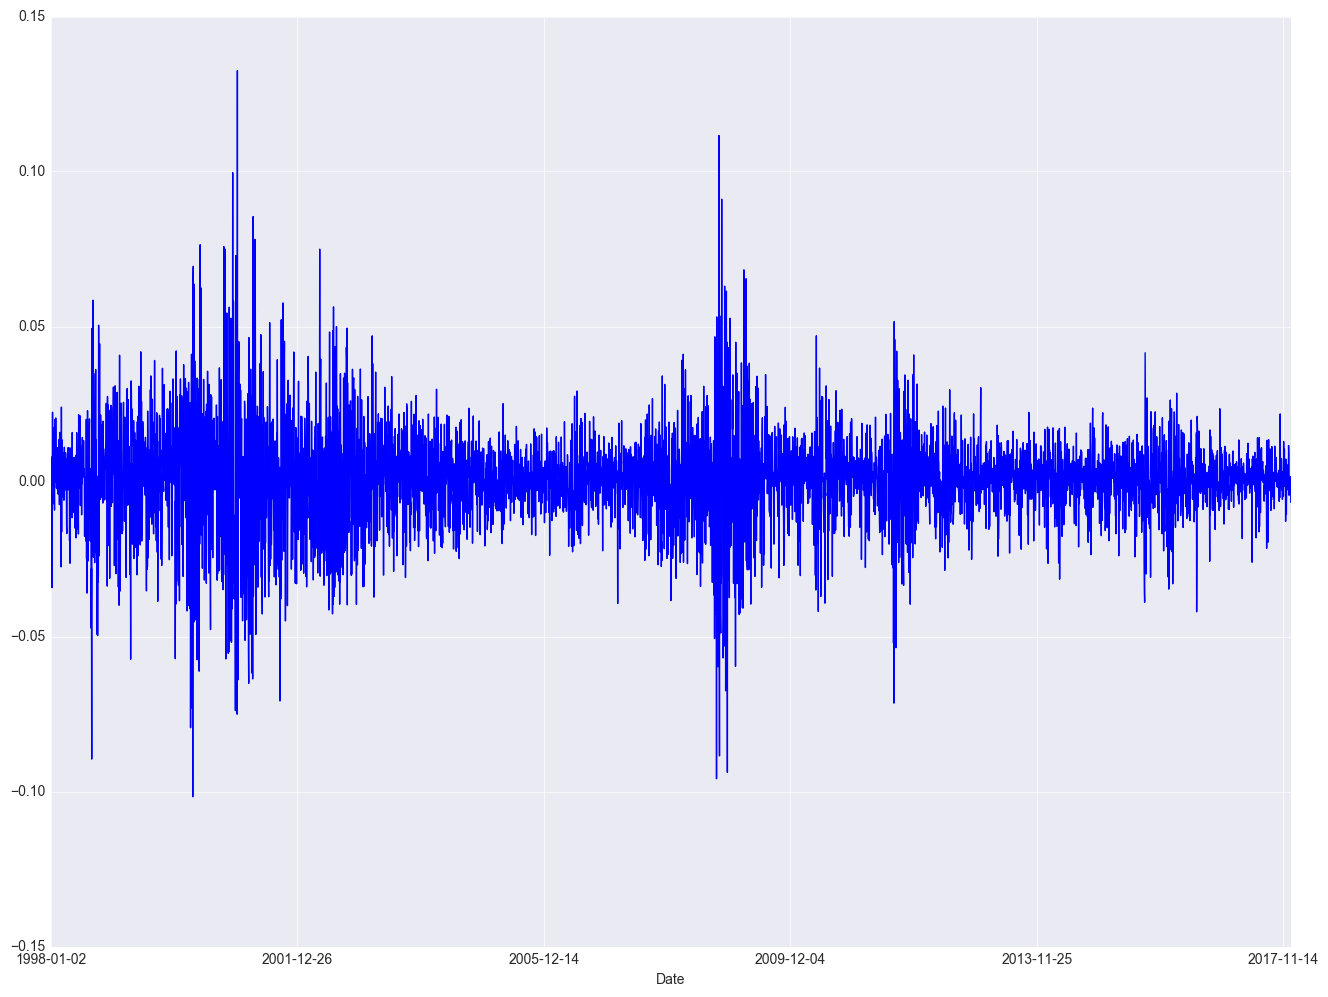

In [20]:
d['logged first difference']=d['natural log']-d['natural log'].shift()
d['logged first difference'].plot(figsize=(16,12))

In [21]:
## test whether the data after the combination of log-transform and first difference will be stationary or not by ADF test

adf_test(d['logged first difference'].iloc[1:])

## By ADF test, we have p-value is 4.818723e-23<<0.01 
## and the test statistics is -12.38975 much smaller than all the critical value (even 1%).

## So the data after log-transformation and first difference is well stationary.

Results of Augment Dickey-Fuller Test:
Test Statistic                -1.238975e+01
p-value                        4.818723e-23
#Lags Used                     2.600000e+01
Number of Observations Used    5.004000e+03
Critical Value (5%)           -2.862118e+00
Critical Value (10%)          -2.567078e+00
Critical Value (1%)           -3.431657e+00
dtype: float64


In [22]:
## Now that the data after first difference and the combination are well stationary, which one should we choose?
## that qeustion equals to whether the log-transform has significant effect on transformation.
## we can check that by applying rolling statistics as follows.

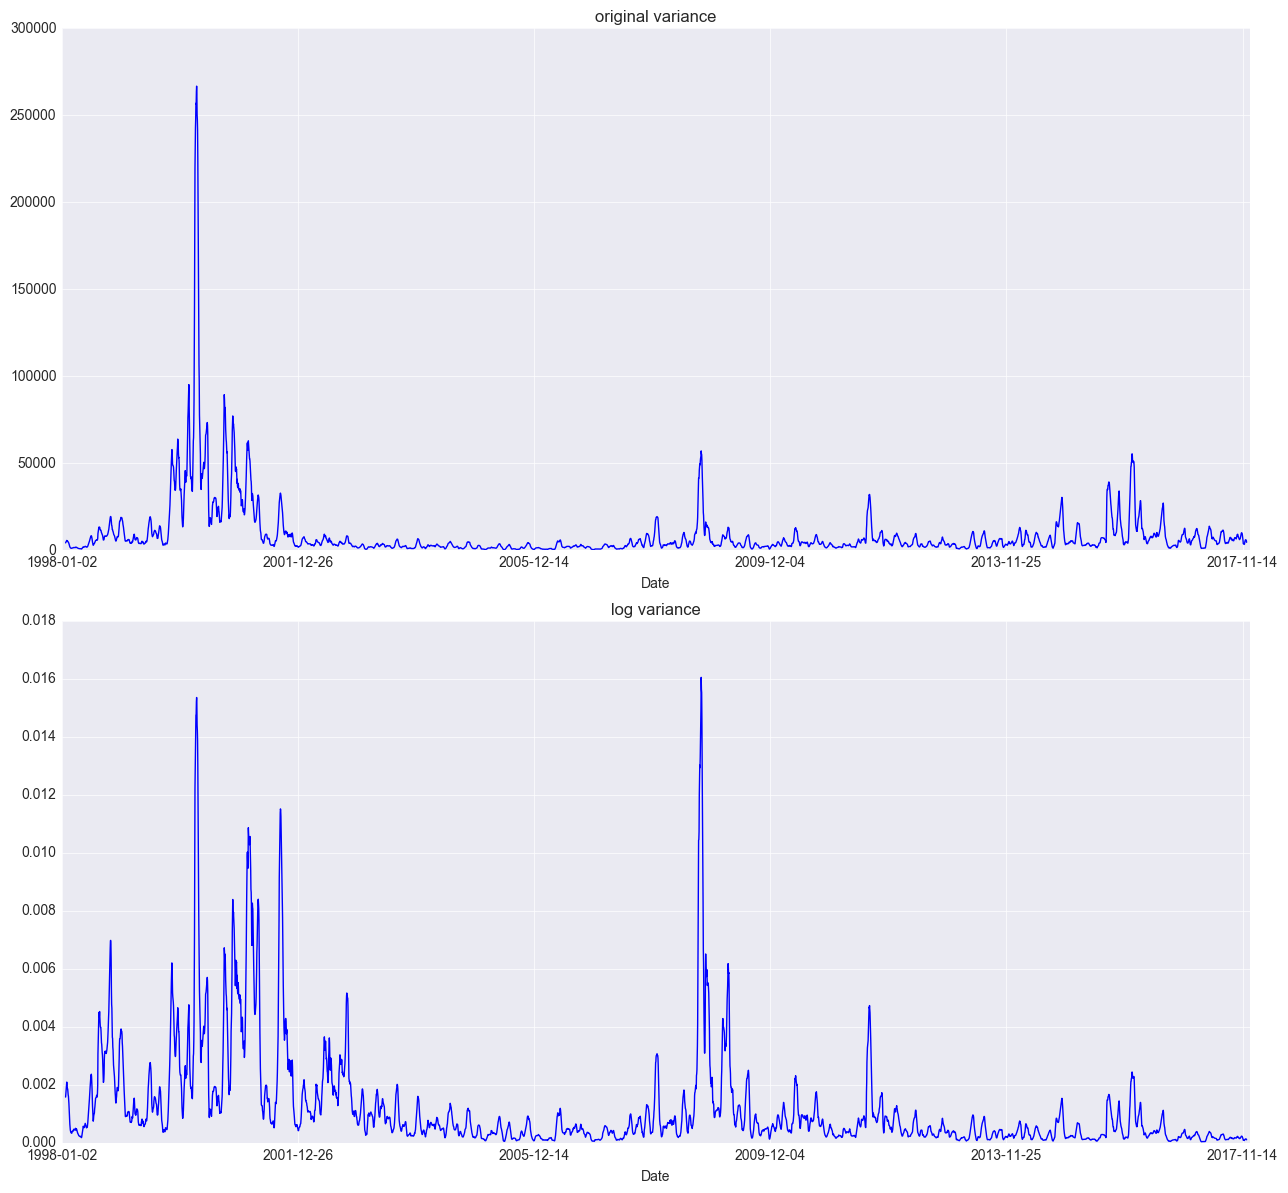

In [23]:
d['original variance']=d['Close'].rolling(center=True,window=30).var()
d['log variance']=d['natural log'].rolling(center=True,window=30).var()
fig,ax=plt.subplots(2,1,figsize=(13,12))
d['original variance'].plot(ax=ax[0],title='original variance')
d['log variance'].plot(ax=ax[1],title='log variance')
fig.tight_layout()  

In [24]:
## From the above comparison plots, it implies that the log-transform has made the variance relatively constant.
## Besides, the ADF test shows that transform including log-transform can gain a better p-value.
## So we'd better apply the data after log-transformation and first difference to following model building.

In [25]:
#######################################################
###### the following part is to build ARIMA model #####
#######################################################

In [26]:
## all of following model are based on the data after log-transform and first difference, 
## which defines that d of the ARIMA model is known and equals to 0 
## because the data is already applied first difference before model-building.

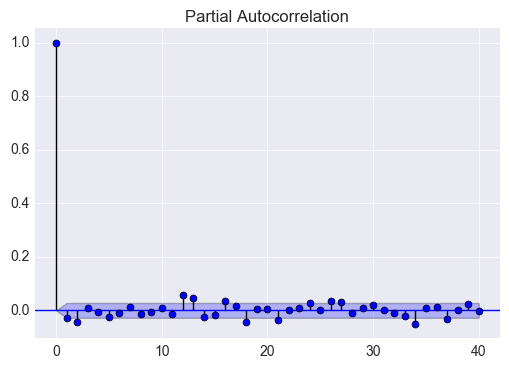

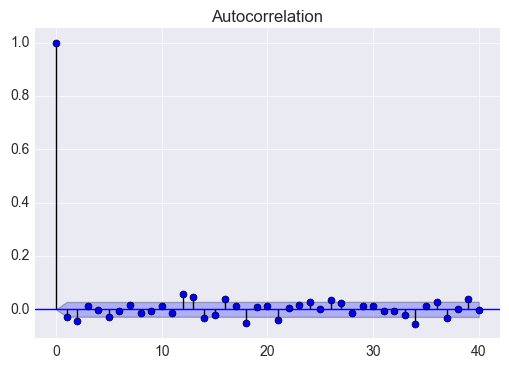

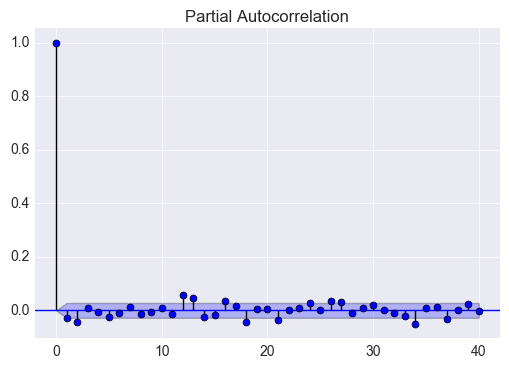

In [27]:
## Fist of all, the parameters, p and q, should be gained by ACF and PACF plots.

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(d['logged first difference'].iloc[1:],lags=40)
plot_pacf(d['logged first difference'].iloc[1:],lags=40)

## the pictures below show that the auto-correlation and partial-autocorrelation results are approximately the same with each other. 
## Almost all of the points are within the blue area, except for one big line and several occasional line, 
## that means p might equal to 1,2,3 and q might equal to 1,2,3 as well.


In [28]:
## Since we have already got the p, d, q value, we should try to build ARIMA model though there are several value of p and q.
## and test the model to get the relatively best one.

In [29]:
## build ARIMA(1,0,1) and test it by D-W test 

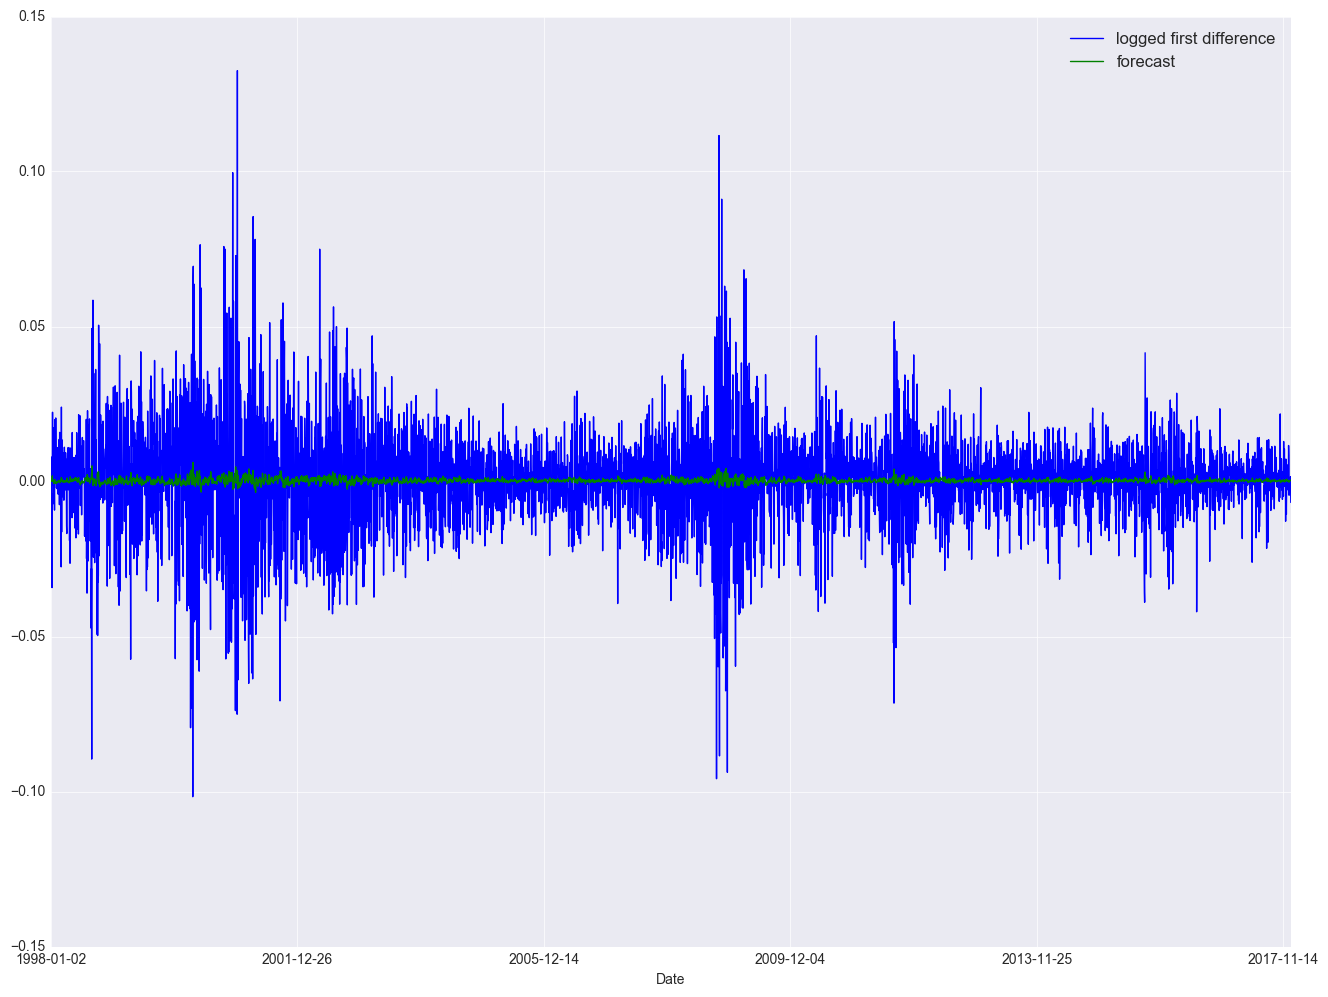

In [32]:
d1=d.reset_index()
date=pd.to_datetime(d.index[1:])
model=sm.tsa.ARIMA(d1['logged first difference'].iloc[1:],dates=date,order=(1,0,1))
results=model.fit(disp=-1)
d['forecast']=results.fittedvalues
d[['logged first difference','forecast']].plot(figsize=(16,12))
plt.plot(results.fittedvalues,color='g')

## We can see the variations of our prediction is very small compared with the actual value.

In [33]:
## test it by D-W test for detecting autocorrelation

sm.stats.durbin_watson(results.fittedvalues)

## the statistics value is 0.657578, which is close to 0, meaning that the errors are probably serially correlated. 
## So this is not the right model and then there is no need to test normality.

0.65757886435417756

In [34]:
## build ARIMA(2,0,2) and test it by D-W test 

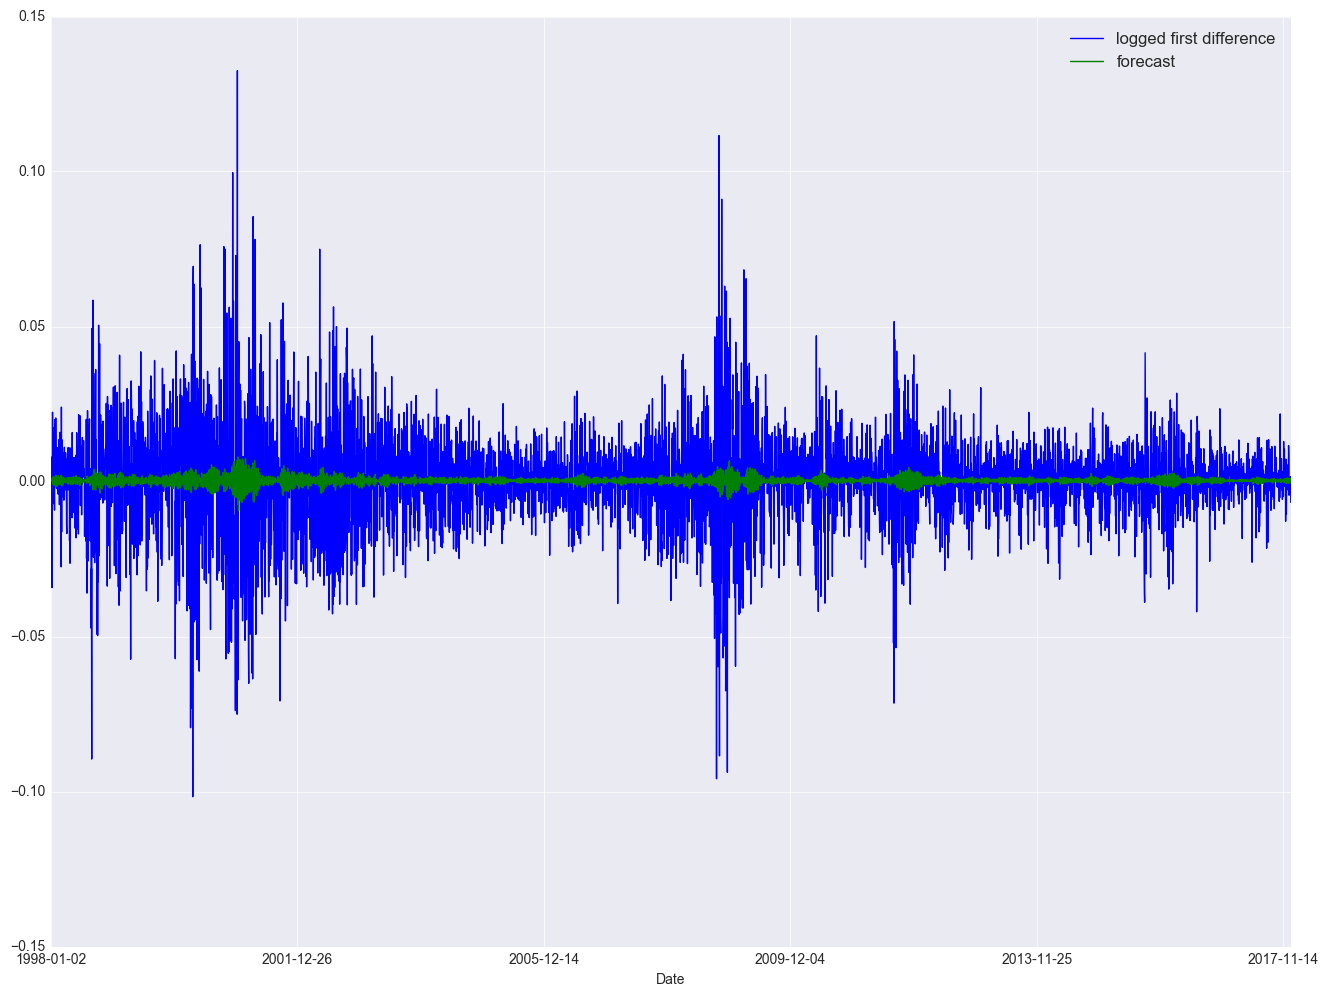

In [35]:
model=sm.tsa.ARIMA(d1['logged first difference'].iloc[1:],dates=date,order=(2,0,2))
results=model.fit(disp=-1)
d['forecast']=results.fittedvalues
d[['logged first difference','forecast']].plot(figsize=(16,12))
plt.plot(results.fittedvalues,color='g')

## The plot shows that the variations of the forecast is getting bigger 

In [36]:
## test it by D-W test for detecting autocorrelation

sm.stats.durbin_watson(results.fittedvalues)

## we gain the D-W value, 2.448557, near to 2, from the test. 
## It implies that the errors are serially uncorrelated. 
## The model is good but not necessarily perfect for this case.

2.4485572597286067

In [37]:
## build ARIMA(3,0,3) and test it by D-W test 

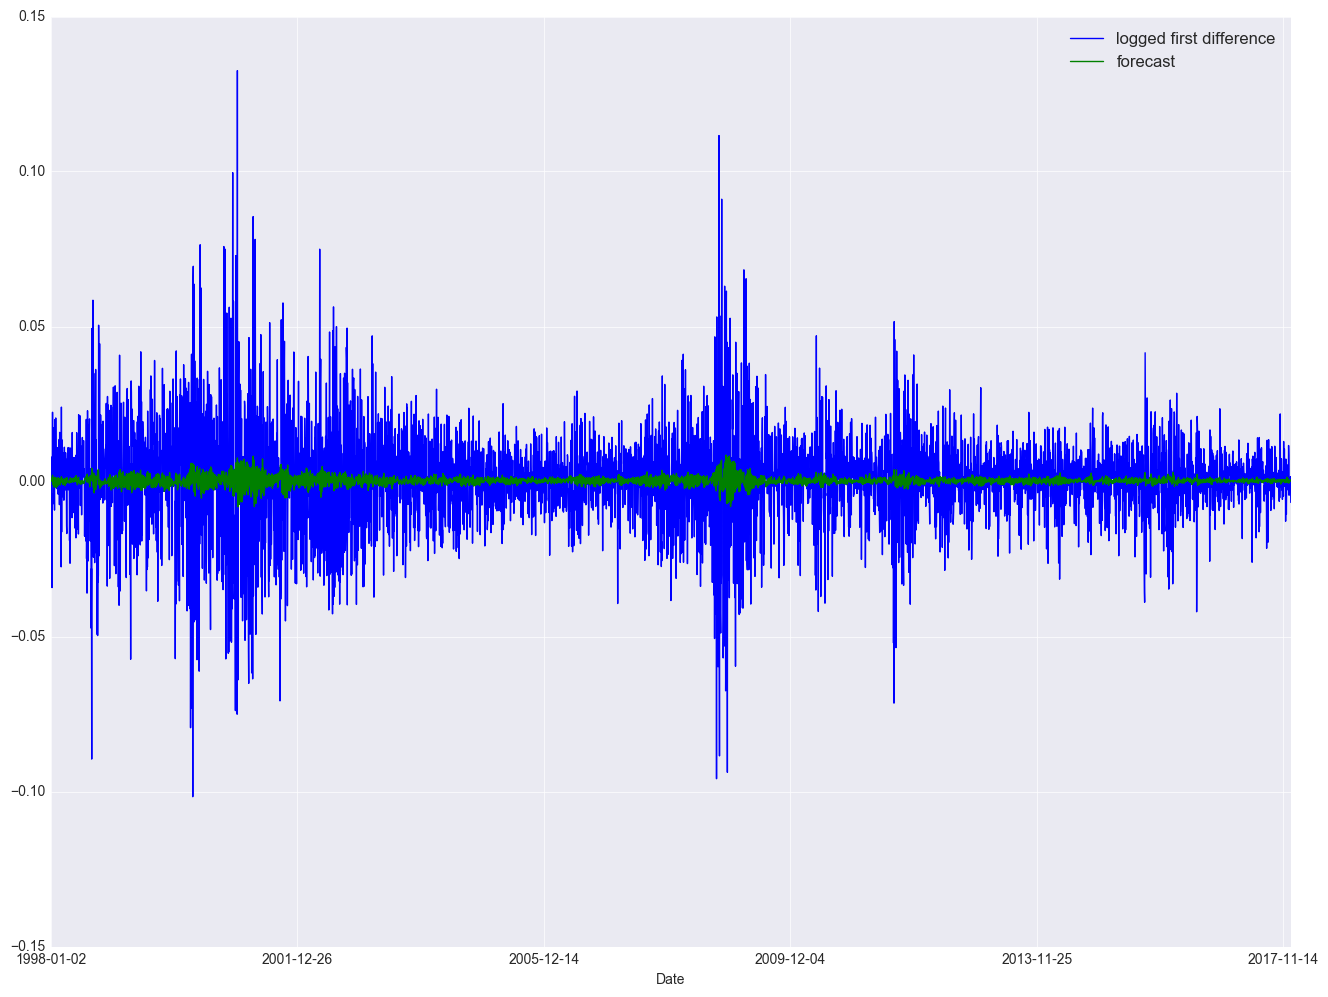

In [40]:
model=sm.tsa.ARIMA(d1['logged first difference'].iloc[1:],dates=date,order=(3,0,3))
results=model.fit(disp=-1,maxiter=200)
d['forecast']=results.fittedvalues
d[['logged first difference','forecast']].plot(figsize=(16,12))
plt.plot(results.fittedvalues,color='g')

## the variations of the forecast is getting bigger compared with the previous model 

In [41]:
## test it by D-W test for detecting autocorrelation

sm.stats.durbin_watson(results.fittedvalues)

## we get 2.1067235 from the D-W test, which is the most close one to 2.

2.107240878282965

In [42]:
## From the above model-building, we obtain a relatively good model, which is ARIMA(3,0,3).
## Then we need to test its normality.

In [43]:
## test the normality of ARIMA(3,0,3) by QQ-plot

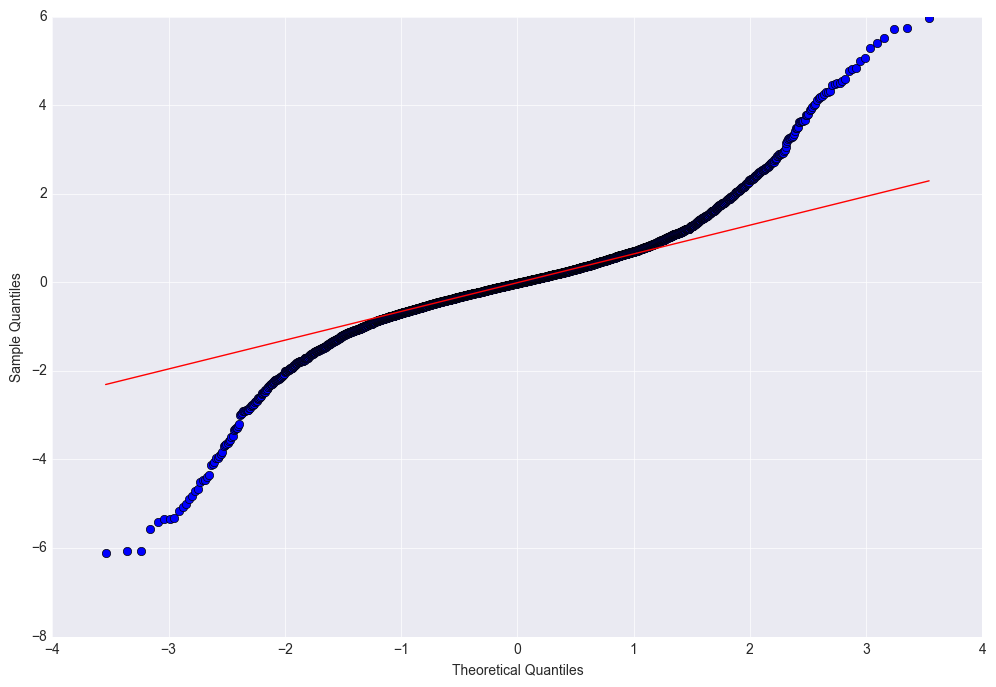

In [45]:
from statsmodels.graphics.api import qqplot

resid = results.fittedvalues
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

In [46]:
## From QQ-plot, those point are approximately overlapping upon the line. 
## In other words, it satisfies the requirement of QQ-plot 
## So the model passes the normality test as well.

In [47]:
##### Therefore, we obtain the final valid model, that is ARIMA(3,0,3).

In [48]:
#####################################
##### comparison for prediction #####
#####################################

In [49]:
## read the two dataset, S&P 500 index and Dow Jones Industrial Average, from CSV file
## and transform them into needed format

spdata=pd.read_csv('example.csv')
dj=pd.read_csv('dj.csv')

spd=spdata.loc[:,('Date','Close')]
spd=spd.set_index('Date')
dj=dj.loc[:,('Date','Close')]
dj=dj.set_index('Date')

In [50]:
## compare NASDAQ and S&P 500 index by correlation analysis and plot

            Close_NASDAQ   Close_S$P
Date                                
1998-01-02   1581.530029  975.039978
1998-01-05   1594.119995  977.070007
1998-01-06   1580.140015  966.580017
1998-01-07   1561.699951  964.000000
1998-01-08   1555.540039  956.049988
              Close_NASDAQ  Close_S$P
Close_NASDAQ      1.000000   0.969453
Close_S$P         0.969453   1.000000


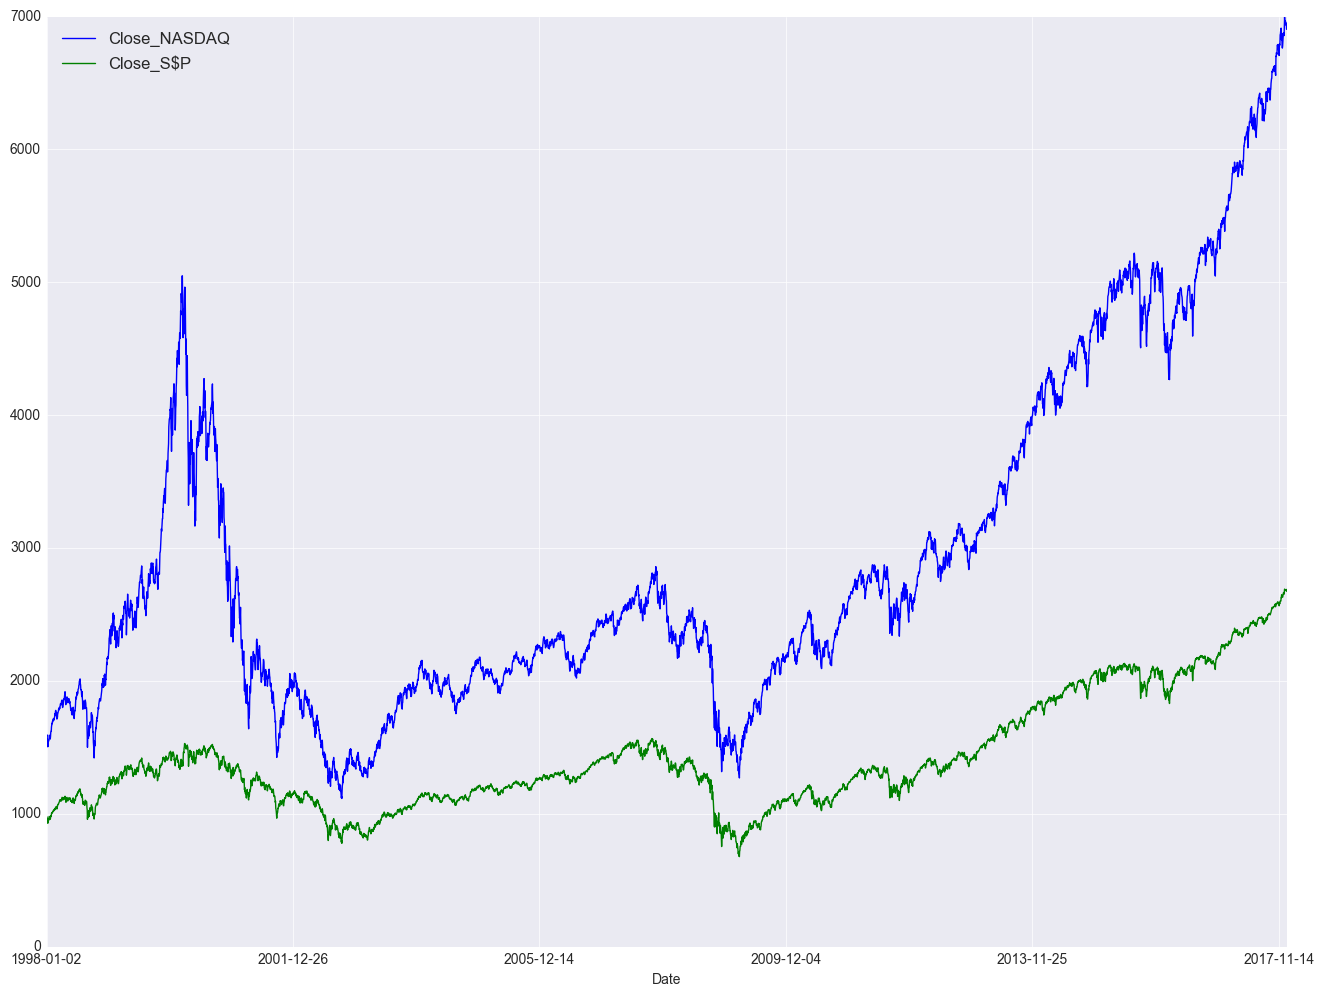

In [53]:
Nd=d['Close']
Nd=Nd.to_frame()
df=Nd.merge(spd,left_index=True,right_index=True,suffixes=['_NASDAQ','_S$P'])
print(df.head())
corr = df.corr(method = 'pearson', min_periods = 365)  
print(corr)  
df.plot(figsize = (16,12))

In [54]:
## In view of the picture, we can say there must be a general trend between them because of the almost same ups and downs. 
## After correlation analysis, we have the correlation between NASDAQ and S&P 500 index is 0.9695, which is high.

In [55]:
## compare NASDAQ and Dow Jones Industrial Average by correlation analysis and plot

            Close_NASDAQ  Close_DowJones
Date                                    
1998-01-02   1581.530029     7965.000000
1998-01-05   1594.119995     7979.000000
1998-01-06   1580.140015     7906.250000
1998-01-07   1561.699951     7902.299805
1998-01-08   1555.540039     7802.600098
                Close_NASDAQ  Close_DowJones
Close_NASDAQ        1.000000        0.938888
Close_DowJones      0.938888        1.000000


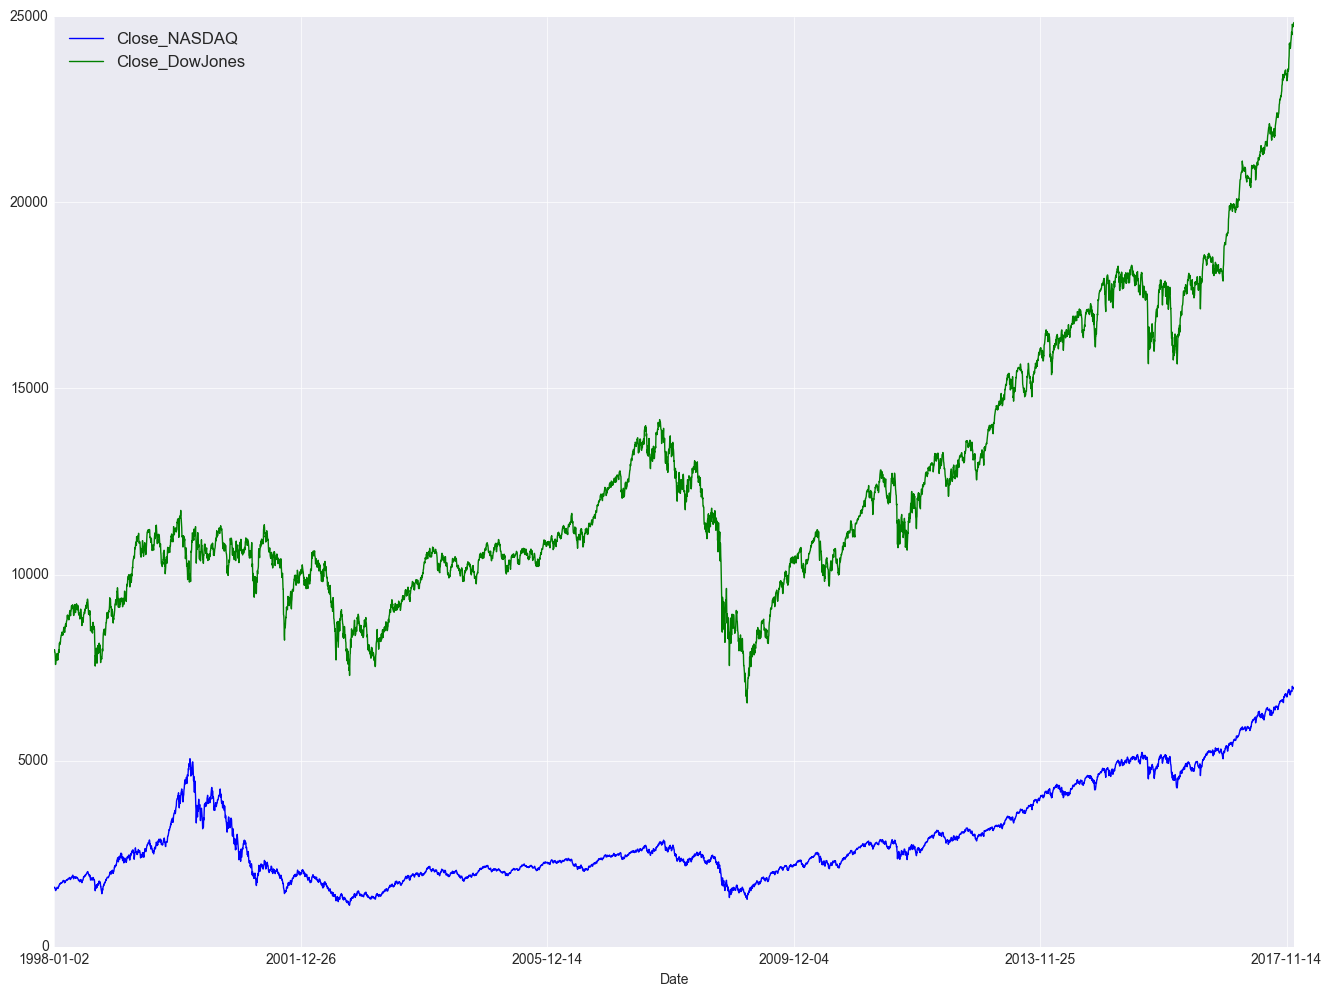

In [56]:
df1=Nd.merge(dj,left_index=True,right_index=True,suffixes=['_NASDAQ','_DowJones'])
print(df1.head())
corr = df1.corr(method = 'pearson', min_periods = 365)  
print(corr)  
df1.plot(figsize = (16,12))

In [57]:
## the green line is the data of Dow Jones Industrial Average and the blue one is that of NASDAQ
## we can say there may be a general trend between them from the above picture,
## because several big ups and downs is corresponding and the trend is both going up. 

## After correlation analysis, we have the correlation between NASDAQ and Dow Jones Industrial Average is 0.9388, 
## which is lower than the correlation between NASDAQ and S&P 500 index (0.9695).

In [58]:
## From the above correlation analysis and plot comparison, there is a conclusion we can make, 
## that is, NASDAQ is more related with S&P 500 index than Dow Jones Industrial Average.
## To predict the trend of NASDAQ, you’d better pay attention to S&P 500 index than Dow Jones.

In [59]:
## out of curiosity, let's compare Dow Jones Industrial Average and S&P 500 index by correlation and plots

             Close_S$P  Close_DowJones
Date                                  
1998-01-02  975.039978     7965.000000
1998-01-05  977.070007     7979.000000
1998-01-06  966.580017     7906.250000
1998-01-07  964.000000     7902.299805
1998-01-08  956.049988     7802.600098
                Close_S$P  Close_DowJones
Close_S$P        1.000000        0.979873
Close_DowJones   0.979873        1.000000


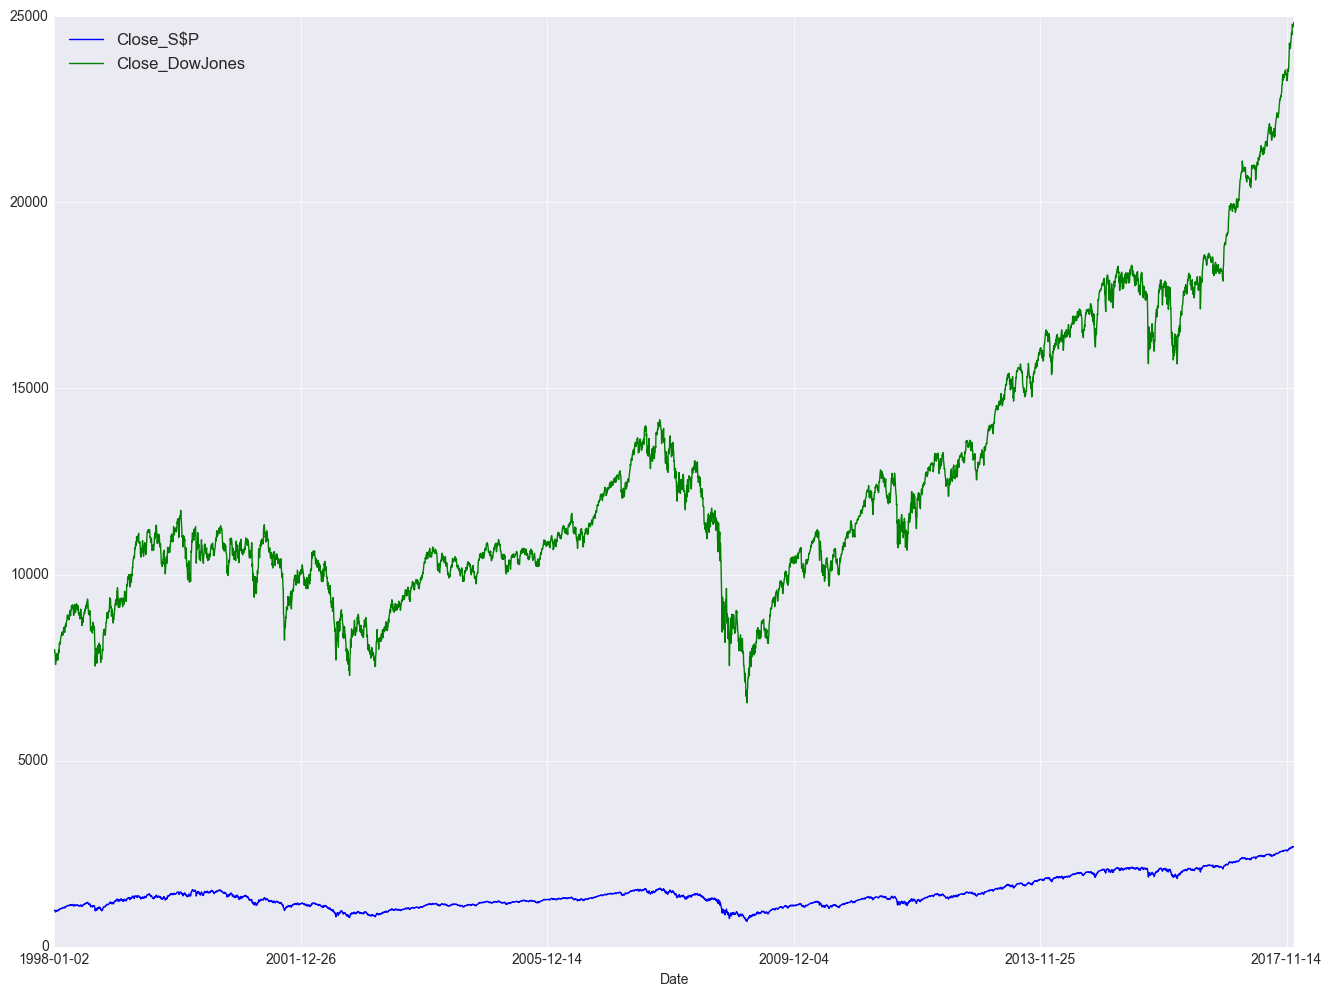

In [64]:
df2=spd.merge(dj,left_index=True,right_index=True,suffixes=['_S$P','_DowJones'])
print(df2.head())
corr = df2.corr(method = 'pearson', min_periods = 365)  
print(corr)  
df2.plot(figsize = (16,12))

In [65]:
## from the plot, there is not much similarity of them, but we can tell by the correlation between them which is 0.979873,
## that S&P 500 index has the highest correlation with Dow Jones index among the correlations of these three.

In [66]:
########################################################
##### Conclusion of the whole time series analysis #####
########################################################

In [67]:
##1## ARIMA(3,0,3) is the optimal model for NASDAQ in our case where it passes all the test.
##2## To predict the trend of NASDAQ, you’d better pay attention to S&P 500 index than Dow Jones.

In [ ]:
################################# end #####################################